**Cloning Github Repository**

In [ ]:
!git clone https://github.com/call-me-jot/surface-crack-detector.git
%cd /content/surface-crack-detector
!git branch Inception
!git checkout Inception

Cloning into 'surface-crack-detector'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 2), reused 6 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 693.69 KiB | 1.88 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/surface-crack-detector
Switched to branch 'Inception'


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import files
import zipfile
import os

In [ ]:
zip_path = "/content/dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")


In [ ]:
dataset_path = "/content/dataset"
positive_dir = os.path.join(dataset_path, "Positive")  # Crack images
negative_dir = os.path.join(dataset_path, "Negative")  # No-crack images

crack_images = glob(os.path.join(positive_dir, "*.jpg"))
no_crack_images = glob(os.path.join(negative_dir, "*.jpg"))

print(f"Total Crack Images: {len(crack_images)}")
print(f"Total No-Crack Images: {len(no_crack_images)}")


Total Crack Images: 20000
Total No-Crack Images: 20000


<ipython-input-9-7a83c103eb35>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="coolwarm")


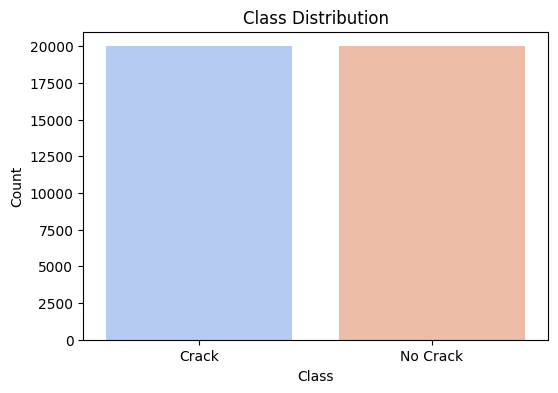

In [ ]:
labels = ['Crack'] * len(crack_images) + ['No Crack'] * len(no_crack_images)

plt.figure(figsize=(6, 4))
sns.countplot(x=labels, palette="coolwarm")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Checking Image Sizes**

Average Image Width: 227.00, Height: 227.00


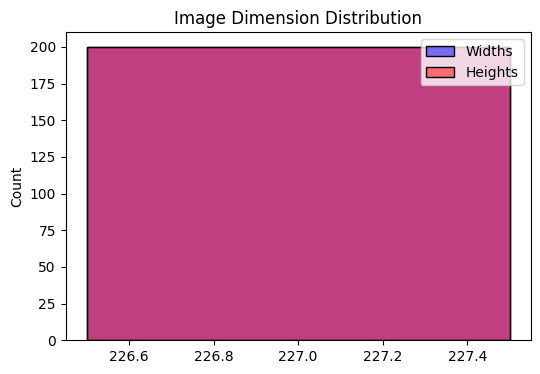

In [ ]:
image_sizes = []
for img_path in crack_images[:100] + no_crack_images[:100]:
    img = Image.open(img_path)
    image_sizes.append(img.size)

widths, heights = zip(*image_sizes)
print(f"Average Image Width: {np.mean(widths):.2f}, Height: {np.mean(heights):.2f}")

plt.figure(figsize=(6, 4))
sns.histplot(widths, kde=True, color="blue", label="Widths")
sns.histplot(heights, kde=True, color="red", label="Heights")
plt.legend()
plt.title("Image Dimension Distribution")
plt.show()


**Compute Image Stats(Mean & Std)**

In [ ]:
def calculate_stats(image_list):
    means, stds = [], []

    for img_path in image_list[:500]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
        means.append(np.mean(img))
        stds.append(np.std(img))

    return np.mean(means), np.mean(stds)

crack_mean, crack_std = calculate_stats(crack_images)
no_crack_mean, no_crack_std = calculate_stats(no_crack_images)

print(f"Crack Images - Mean: {crack_mean:.3f}, Std: {crack_std:.3f}")
print(f"No Crack Images - Mean: {no_crack_mean:.3f}, Std: {no_crack_std:.3f}")


Crack Images - Mean: 0.647, Std: 0.121
No Crack Images - Mean: 0.709, Std: 0.035


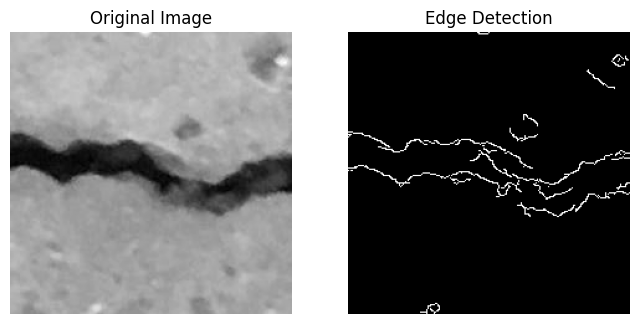

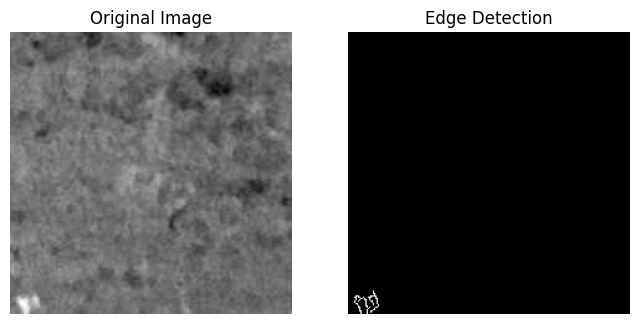

In [ ]:
def show_edges(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, threshold1=50, threshold2=150)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Edge Detection")
    plt.axis("off")

    plt.show()

show_edges(crack_images[0])
show_edges(no_crack_images[0])


Loading Dataset with Normalization

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize (0 to 1)
    validation_split=0.2  # 80-20 train-validation
)

# Load training
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Load validation
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


Data Augmentation

In [ ]:
# Define augmentation
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Apply augmentation
train_augmented = augment_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)


Found 32000 images belonging to 2 classes.


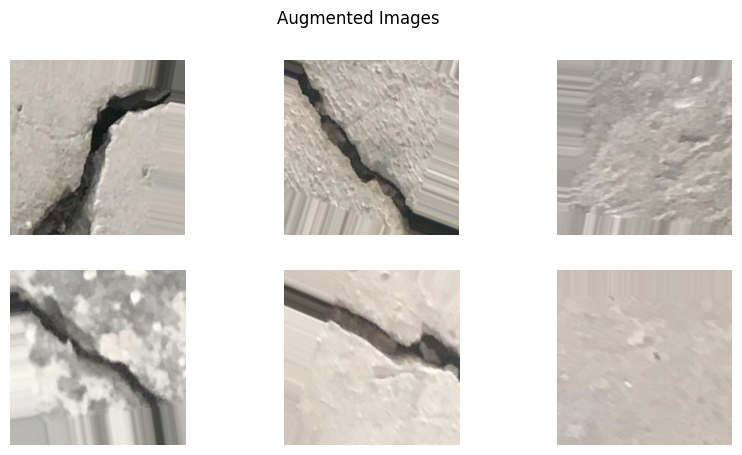

In [ ]:
import matplotlib.pyplot as plt

augmented_images, _ = next(train_augmented)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.suptitle("Augmented Images")
plt.show()


Inception Based-Model

In [ ]:
from tensorflow.keras import layers, models, Input

# Inception module
def inception_module(x, filters):
    f1, f2, f3 = filters

    conv1x1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)

    conv3x3 = layers.Conv2D(f2, (3,3), padding='same', activation='relu')(x)

    conv5x5 = layers.Conv2D(f3, (5,5), padding='same', activation='relu')(x)

    maxpool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    maxpool = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(maxpool)

    output = layers.concatenate([conv1x1, conv3x3, conv5x5, maxpool], axis=-1)
    return output

# Inception-based model
input_layer = Input(shape=(224, 224, 3))

x = layers.Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

x = inception_module(x, [32, 64, 64])
x = inception_module(x, [64, 128, 128])
x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

x = inception_module(x, [128, 256, 256])
x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ max_pooling2d[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 32)     │          2,080 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 64)     │        102,464 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 32)     │          2,080 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56, 56, 192)    │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 56, 56, 192)    │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 64)     │         12,352 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 56, 56, 128)    │        221,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 56, 56, 128)    │        614,528 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 56, 56, 64)     │         12,352 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 56, 56, 384)    │              0 │ conv2d_5[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├──────────────────────

 Total params: 42,990,657 (164.00 MB)

 Trainable params: 42,990,657 (164.00 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [ ]:
epochs = 20

history = model.fit(
    train_augmented,
    validation_data=val_data,
    epochs=epochs
)
model.save("inception_trained_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 462s 438ms/step - accuracy: 0.8941 - loss: 0.5142 - val_accuracy: 0.9916 - val_loss: 0.0277
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 428s 428ms/step - accuracy: 0.9814 - loss: 0.0608 - val_accuracy: 0.9895 - val_loss: 0.0496
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 435s 435ms/step - accuracy: 0.9786 - loss: 0.0756 - val_accuracy: 0.9895 - val_loss: 0.0472
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 436s 436ms/step - accuracy: 0.9832 - loss: 0.0532 - val_accuracy: 0.9961 - val_loss: 0.0181
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 424s 424ms/step - accuracy: 0.9894 - loss: 0.0404 - val_accuracy: 0.9979 - val_loss: 0.0107
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 423s 423ms/step - accuracy: 0.9872 - loss: 0.0449 - val_accuracy: 0.9929 - val_loss: 0.0244
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 422s 422ms/step - accuracy: 0.9876 - loss: 0.0442 - val_accuracy: 0.9973 - val_loss: 0.0109
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 442s 442ms/step - ac

In [ ]:
print("Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

Accuracy: 0.9948750138282776
Validation Accuracy: 0.9992499947547913


**Plotting**

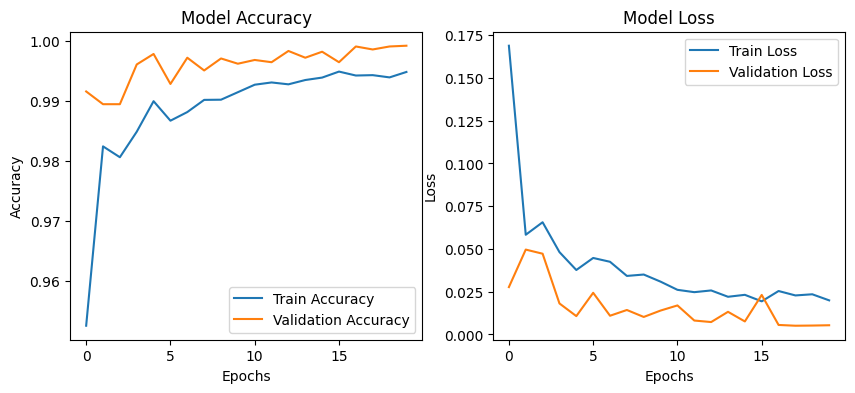

In [ ]:
import matplotlib.pyplot as plt

# Accuracy & loss
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")

plt.show()


**Test**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/inception_trained_model.h5')

Mounted at /content/drive


In [ ]:
!cd /content/surface-crack-detector
!git branch
!git add inception_trained_model
!git add inception_trained_model.h5
!git commit -m "Added trained Inception model"

* Inception
  master
fatal: pathspec 'inception_trained_model' did not match any files
[Inception 7c1dcfc] Added trained Inception model
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 inception_trained_model.h5


In [ ]:
!git config --global user.email "ssamieik@uwo.ca"
!git config --global user.name "Coding-Ali"

In [ ]:
!git push origin Inception

fatal: could not read Username for 'https://github.com': No such device or address
